## Identifying and Collecting Children's and Young Adult Fiction Books

In [9]:
import pandas as pd
import numpy as np
import json
from htrc_features import Volume
from compare_tools.hathimeta import HathiMeta
from compare_tools.configuration import config
config.update(config['full'])
meta = HathiMeta(config['metadb_path'])

In [4]:
all_classes = []
with open('/data/hathifiles/classification_nums.csv', mode='r') as f:
    for line in f.readlines():
        try:
            htid, raw_class = line.strip().split('\t')
        except:
            continue
        class_dict = json.loads(raw_class)
        if class_dict is not None:
            lcc = class_dict['lcc'] if 'lcc' in class_dict else None
            ddc = class_dict['ddc'] if 'ddc' in class_dict else None
            all_classes.append((htid, lcc, ddc))
        else:
            all_classes.append((htid, None, None))
df = pd.DataFrame(all_classes, columns=['htid','lcc','ddc'])

On classifying Children's and Young Adult books.

https://www.loc.gov/aba/cyac/classification.html

PZ7 in LCC

```
[E] and [Fic] appear on CYAC records in the 082, Dewey Decimal Classification number field.

[E] is used for easy fiction intended for children through grade 3 or age 8. With the exception of alphabet and counting books, [E] is not used on nonfiction material. [Fic] applies to fiction for children beyond grade 3 or age 8, as well as young adults through high school.  These designations are added by CYAC catalogers.
```

In [5]:
ddc_matches = df.ddc.apply(json.dumps).str.contains('\[(E|Fic)\]')
lcc_matches = df.lcc.apply(json.dumps).str.contains('PZ7')
kidsbooks = df[lcc_matches | ddc_matches]
print(kidsbooks.shape)
kidsbooks.sample(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/strings.py:1947: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(14493, 3)


,htid,lcc,ddc
7068025,pst.000066878674,[PZ7.R982 Ant 2008],[[E]]
5444318,nnc1.cu12144312,[PZ7 .M147R],None
4986023,pst.000059032465,[PZ7.R5446 At 1986],[[Fic]]
1961294,mdp.39015005156735,[PZ7.S5594 On],[[E]]
7778933,txu.059173019196864,[PZ73 .C86 2005],[[E]]
2030189,mdp.39015011331504,[PZ7.N82 Mo],[[Fic]]
1960719,mdp.39015024085428,[PZ7.E587 Sw],None
7068158,pst.000024772051,[PZ7.G6696 Gh 1985],None
3461949,mdp.39015058278360,[PZ7.R9 Ki],None
5003145,pst.000033576626,[PZ7.D922 Ed 1983],None


In [12]:
allmeta = meta.get_fields(fields=['htid', 'title', 'rights_date_used'])
subset = allmeta[allmeta.htid.isin(kidsbooks.htid)]
del allmeta
subset.sample(10)

,htid,title,rights_date_used
4080159,uc1.b4098809,"Drake, the man they called a pirate.",1960
7124329,pst.000044815219,Will somebody please marry my sister? / Eth Cl...,1992
5418193,nyp.33433082530464,Elsie's new relations: what they did and how t...,1883
3521380,mdp.49015000911777,Hiccup / by Mercer Mayer.,1976
4301937,txu.059173025377670,Drought.,1966
2286638,mdp.39015009788384,Big bridge to Brooklyn; the Roebling story.,1956
4298591,uc1.$b115742,"Letty, a study of a child / Rose Fyleman ; wit...",1927
3621981,mdp.39015062489037,Just going to the dentist / by Mercer Mayer.,1990
8154981,umn.31951000783935i,Chick-chick here.,1957
2630916,mdp.39015008295639,Bright Fawn and me / by Jay Leech and Zane Spe...,1979


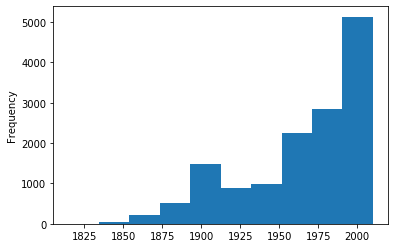

In [13]:
subset.rights_date_used[subset.rights_date_used < 2018].plot(kind='hist')

In [ ]:
def get_all_booklist_tokens(htids):
    collector = []
    all_df = pd.DataFrame([], columns=['lowercase', 'count'])
    for i, htid in enumerate(htids):
        try:
            vol = Volume(htid, format='parquet', id_resolver='stubbytree',
                         dir='/data/extracted-features-parquet-stubby/')
            tl = vol.tokenlist(pos=False, pages=False, case=False)
        except:
            print('Err', htid)
            continue
        tl = tl[tl['count'] > 2].reset_index()
        collector.append(tl)
        if i % 100 == 0:
            print(i, end=',')
            all_df = pd.concat(collector).groupby('lowercase', as_index=False).sum()
            all_df = all_df[all_df['count'] > 15]
            collector = [all_df]
    all_df = pd.concat(collector).groupby('lowercase').sum()
    all_df = all_df[all_df['count'] > 15]
    print()
    # TODO ODDS RATIO AGAINST RANDOM BOOKS
    all_df['odds'] = all_df['count'] / all_df['count'].sum()
    return all_df

kids_tokens = get_all_booklist_tokens(kidsbooks.htid)

In [ ]:
rand_books = meta.sample(n=kidsbooks.shape[0], fields=['htid'])
rand_tokens = get_all_booklist_tokens(rand_books.htid)

Calculate Odds ratio between random books and kids books.

In [24]:
kodds = kids_tokens[kids_tokens['count'] > 300]['odds']
rodds = rand_tokens[rand_tokens['count'] > 300]['odds']
a = kodds / rodds
b = a.dropna().sort_values(ascending=False)
b.head(40)

lowercase
heidi       88.090904
dad         85.208264
mom         83.681263
grandpa     72.289692
hugged      72.186902
grinned     67.751733
blinked     67.152995
she’d       66.114792
mumbled     63.883784
grandma     63.313912
nodded      62.076197
“you’re     60.642638
sniffed     60.233520
yelled      57.929637
brer        55.645651
henty       55.491083
mama        55.356594
momma       54.981024
poked       53.458201
trotted     53.052295
peered      52.330720
shivered    52.204611
chuckled    51.837807
smelled     51.400973
i'll        50.283764
grabbed     49.707591
“that’s     49.421746
he’d        49.042239
patted      48.896372
shrugged    48.626655
gasped      48.492204
okay        48.315384
t-shirt     48.303206
grunted     47.253920
frowned     46.760999
georgie     46.589193
hissed      46.285349
patty       46.074249
jody        45.997321
skinny      45.766548
Name: odds, dtype: float64

Words that are in the top 10k of the kids corpus but not then random books.

In [25]:
print(list(set(kodds.sort_values(ascending=False).head(10000).index).difference(rodds.sort_values(ascending=False).head(10000).index)))

['kicking', '12mo', 'outfit', 'straps', 'lagoon', 'warmed', 'backs', 'pinched', 'patrol', 'momo', 'apologize', 'stair', 'phantom', 'persuade', 'sallie', 'schoolmaster', 'toe', 'bandits', 'kissed', 'rustling', 'whispering', 'aroused', 'thumb', 'ramp', 'cups', 'dandy', 'hullo', 'delia', 'katy', 'sledge', 'alaine', 'mollie', 'terence', '"how', 'hog', '“so', 'gaunt', 'jessica', 'perched', 'mutiny', 'disappointed', 'cute', 'muttered', 'thief', 'agony', 'bandit', 'duff', 'panther', 'shovel', 'graveyard', 'lavinia', 'laurence', 'nods', 'tasted', 'camilla', 'humphrey', 'roofs', 'choked', 'neatly', 'troubled', '“don’t', 'comrade', 'liza', 'wept', 'araminta', 'dripping', 'perrine', 'sentries', 'tightly', 'boatswain', 'knots', 'cricket', 'zoe', 'swear', 'penguin', 'tempted', 'yankees', 'stubborn', 'canoe', 'stays', 'rug', 'dreary', 'nico', '‘it', 'آ', 'locker', 'clifton', 'geoffrey', 'miranda', 'sheridan', 'falcon', 'balloon', 'frown', 'steaming', 'dey', 'trifle', 'cans', 'prue', 'hush', 'mallevi

Words that are disproportionately in the random corpus. Filtering by word lengthto avoid math symbols.

In [26]:
b[b.index.to_series().astype(str).apply(len) > 2].sort_values().head(40)

lowercase
analysis           0.003880
rates              0.004224
systems            0.004496
values             0.004579
products           0.005368
function           0.005540
industrial         0.007381
acid               0.007445
data               0.007642
1975               0.007924
usa                0.008127
estimated          0.008234
sources            0.008467
500                0.008566
characteristics    0.008692
product            0.008768
applications       0.008790
economic           0.008850
maintenance        0.008861
1977               0.009026
transportation     0.009118
agricultural       0.009181
100                0.009481
internal           0.009562
000                0.009656
fig                0.009690
differences        0.009923
employees          0.010200
co.                0.010372
production         0.010450
institutions       0.010602
organizations      0.010727
benefits           0.010765
tel                0.010880
1984               0.011062
units     

In [41]:
words = b[b.index.to_series().astype(str).apply(len) > 2].sort_values().head(200).index.tolist()
print("\t".join([str(word).ljust(15) for word in words]))

analysis       	rates          	systems        	values         	products       	function       	industrial     	acid           	data           	1975           	usa            	estimated      	sources        	500            	characteristics	product        	applications   	economic       	maintenance    	1977           	transportation 	agricultural   	100            	internal       	000            	fig            	differences    	employees      	co.            	production     	institutions   	organizations  	benefits       	tel            	1984           	units          	relatively     	specific       	corporation    	development    	basis          	agriculture    	200            	include        	300            	procedure      	investment     	annual         	technical      	1988           	vol            	areas          	consists       	subsequent     	1987           	technology     	st.            	based          	phase          	chemical       	1986           	samples        	ave     